In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn
import _pickle as cPickle
from scipy.optimize import minimize, rosen, rosen_der
from gekko import GEKKO

<h1>Testando o método <i>minimize</i></h1>
O problema do minimize do sklearn é não permitir trabalhar com variáveis inteiras, o que nos criaria problemas com alguns dos atributos do dataser

<h2>Definindo a função</h2>

In [2]:
def f(x):
    return x[0]*np.sin(x[0])

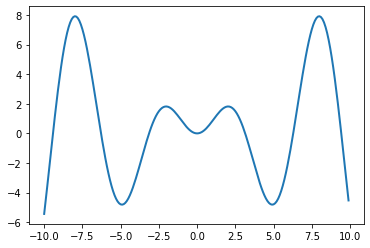

In [3]:
t = np.arange(-10.0, 10.0, 0.1)
s = f([t])
line, = plt.plot(t, s, lw=2)

<h2>Minimizando sem restrições</h2>

In [4]:
x0 = 2.5 #ponto inicial
res = minimize(f, x0)
res

      fun: -4.814469889712268
 hess_inv: array([[0.19183809]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([4.91318043])

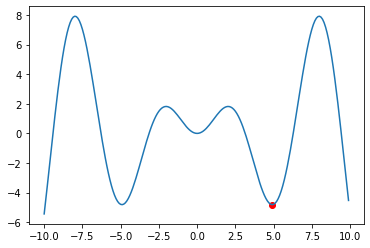

In [5]:
s2 = f([res.x])
plt.plot(res.x, s2, 'ro', t, s)

<h2>Minimizando com limites de intervalo</h2>

In [6]:
bnds = ((1, 4),) # 1 <= x <= 4. Se fosse x >= 2 seria (2, None)
res2 = minimize(f, x0, bounds=bnds)
res2

      fun: -3.027209981231713
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.37137696])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 2
   status: 0
  success: True
        x: array([4.])

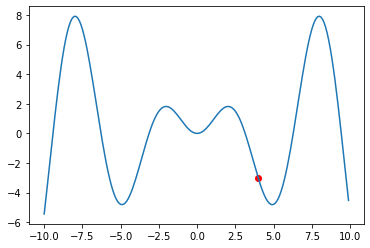

In [7]:
s2 = f([res2.x])
plt.plot(res2.x, s2, 'ro', t, s)

<h2>Minimizando com restrições</h2>

In [8]:
def xMenorIgual4(x): 
    return 4 - x[0]

In [9]:
res3 = minimize(f, x0=2.5, 
                constraints={"type": "ineq",
                             "fun": xMenorIgual4}, 
                options={'disp':True,
                         'maxiter': 5000})
res3

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.027209981232803
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3


     fun: -3.027209981232803
     jac: array([-3.37137696])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([4.])

In [10]:
#para "tornar" a variável inteira, vamos fazer uma pequena gambiarra
def fInt(x):
    return f(np.round(x, 0))

In [11]:
res4 = minimize(fInt, x0=2)
res4

      fun: 1.8185948536513634
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.])

<h1>Testes com GEKKO</h1>

<h2>Mono variável</h2>

In [24]:
m = GEKKO()
m.options.SOLVER = 1

In [25]:
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 10', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 50', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

In [26]:
x = m.Var(value=3, lb=-7, ub=7, integer=True) #solução inteira
x

3

In [27]:
m.Obj(x*m.sin(x))

In [28]:
m.solve()

apm 189.35.246.92_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.00 NLPi:    6 Dpth:    0 Lvs:    2 Obj: -4.81E+00 Gap:       NaN
--Integer Solution:  -3.03E+00 Lowest 

In [29]:
x

[5.0]

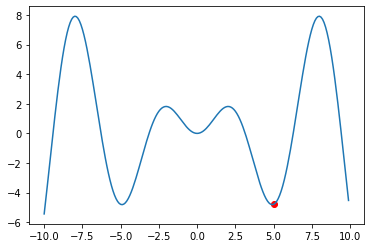

In [30]:
plt.plot(5, f([5]), 'ro', t, s)

<h2>Multivariável com restrições</h2>

In [31]:
m = GEKKO() # Initialize gekko
x1 = m.Var(value=5, lb=1, ub=10)
x2 = m.Var(value=5, lb=1, ub=10)
m.Equation(x1 + x2 <= 10)
m.Equation(x1 >= x2 + 2)
m.Obj(x1*x2*np.sin(x1.value + x2.value))
m.solve()

apm 189.35.246.92_gk_model3 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            4
   Intermediates:            0
   Connections  :            0
   Equations    :            3
   Residuals    :            3
 
 Number of state variables:              4
 Number of total equations: -            2
 Number of slack variables: -            2
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program con

In [32]:
print(x1.value, x2.value)

[6.0000003403] [3.99999965]


In [33]:
x = [x1, x2]
x

[[6.0000003403], [3.99999965]]

In [34]:
def gekko2list(varX):
    l = []
    for x in varX:
        l.append(x[0])
    return l

In [35]:
gekko2list(x)

[6.0000003403, 3.99999965]